✅ Normalized dataset is ready!
Found 13685 images belonging to 3 classes.
Found 3419 images belonging to 3 classes.
Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1894s 6s/step - accuracy: 0.3711 - loss: 1.1314 - val_accuracy: 0.9713 - val_loss: 0.7194
Epoch 2/5
128/300 ━━━━━━━━━━━━━━━━━━━━ 14:05 5s/step - accuracy: 0.5127 - loss: 0.9967

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1103s 4s/step - accuracy: 0.5159 - loss: 0.9968 - val_accuracy: 0.9824 - val_loss: 0.6747
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1893s 6s/step - accuracy: 0.5502 - loss: 0.9623 - val_accuracy: 0.9798 - val_loss: 0.5932
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1104s 4s/step - accuracy: 0.6058 - loss: 0.9068 - val_accuracy: 0.9801 - val_loss: 0.5792
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1912s 6s/step - accuracy: 0.5900 - loss: 0.9094 - val_accuracy: 0.9842 - val_loss: 0.5449


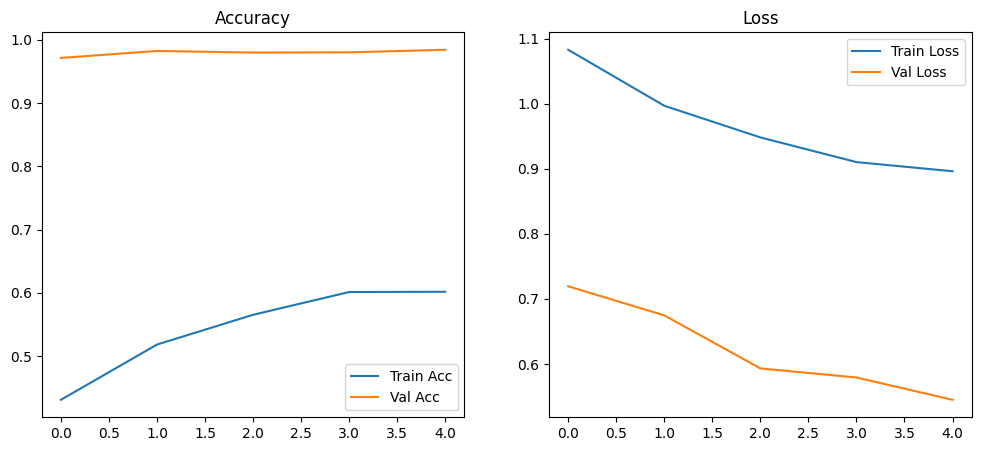

107/107 ━━━━━━━━━━━━━━━━━━━━ 524s 5s/step
🔍 Classification Report:

              precision    recall  f1-score   support

   1NonCOVID       0.95      0.98      0.96      1378
      2COVID       0.72      0.95      0.82      1518
        3CAP       0.00      0.00      0.00       523

    accuracy                           0.82      3419
   macro avg       0.56      0.64      0.59      3419
weighted avg       0.70      0.82      0.75      3419



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


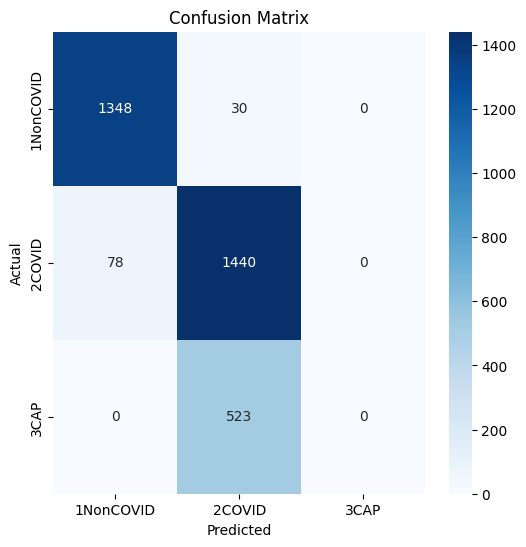

107/107 ━━━━━━━━━━━━━━━━━━━━ 523s 5s/step - accuracy: 0.9557 - loss: 0.5359
✅ Final Accuracy: 0.8154
❌ Error Rate: 18.46%


In [9]:
# ✅ Unzip Normalized Dataset
import zipfile

with zipfile.ZipFile("normalized_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/normalized_dataset")

print("✅ Normalized dataset is ready!")

# 🧪 Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 📁 Dataset paths
data_path = "/content/normalized_dataset/curated_data"
img_size = 128  # ✅ Reduced for speed
batch_size = 32

# 🔄 Data generators
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

train_data = datagen.flow_from_directory(
    data_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    data_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical',
    shuffle=False
)

# 🔧 VGG-19 model
base_model = VGG19(include_top=False, input_shape=(img_size, img_size, 3), weights='imagenet')
base_model.trainable = False  # freeze to speed up

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# 🚀 Compile
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])



# 🏋 Train (fixed, no workers argument)
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    steps_per_epoch=300,      # ✅ Custom steps to reduce time per epoch
    validation_steps=85       # ✅ Custom steps
)


# 💾 Save
model.save("VGG19_COVID_CT_Optimized.h5")

# 📉 Plot history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()

# 📊 Evaluation
val_data.reset()
predictions = model.predict(val_data, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = val_data.classes
class_labels = list(val_data.class_indices.keys())

print("🔍 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# 📉 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 📌 Accuracy & Error
final_loss, final_acc = model.evaluate(val_data)
error_rate = (1 - final_acc) * 100
print(f"✅ Final Accuracy: {final_acc:.4f}")
print(f"❌ Error Rate: {error_rate:.2f}%")
